# TTM fine-tune example on M4 hourly data

This notebook demonstrates the usage of TTM on M4 Hourly dataset.
M4 is a dataset containing multiple univariate time series
from various domains like finance, micro- and macro-industries.
M4 generally falls in the domain of Short-term Forecasting
(See [GPT4TS](https://arxiv.org/pdf/2302.11939.pdf)).

Note that the TTM model was NOT pre-trained on the M4 dataset 
(not on any M datasets). Hence, we will first check the zero-shot 
performance of TTM on M4-hourly data. Then, we will finetune the
TTM model on the `train` split of the M4-hourly data, and 
subsequently re-evaluate it on the `test` split.

M4-hourly has a forecast-horizon of 48 time points. We will use the 
TTM-512-96 model, and truncate the first 48 points from the prediction.
The truncation is done by simply providing the `prediction_filter_length=48`
in the TTM arguments during loading.

Note that other subsets of M4 data like (daily, monthly, quarterly, and yearly)
are shorter in length and are not suitable for TTM-512-96 or TTM-1024-96 model.
Stay tuned for more TTM models!

In [1]:
import math
import os
from collections import OrderedDict
from dataclasses import dataclass
from types import SimpleNamespace

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import Trainer, TrainingArguments, set_seed

from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction

2024-08-21 03:18:35.658196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 03:18:35.700437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 03:18:36.478927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Save the M4 data files here
M4_DATASET_PATH = "datasets/m4"

# Model and results will be saved here
M4_RESULTS_PATH = "ttm_finetuned_models"

# M4 hourly official forecast horizon
M4_FORECAST_HORIZON = 48

# Select device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## M4 hourly data loader preparation

Dataloader and M4 evaluation source codes obtained from: [here](https://github.com/DAMO-DI-ML/NeurIPS2023-One-Fits-All).
We do global normalization/reverse-normalization per time series as per TTM requirement.

#### M4 Meta

In [3]:
@dataclass()
class M4Dataset:
    ids: np.ndarray
    groups: np.ndarray
    frequencies: np.ndarray
    horizons: np.ndarray
    values: np.ndarray

    @staticmethod
    def load(training: bool = True, dataset_file: str = "../dataset/m4") -> "M4Dataset":
        """
        Load cached dataset.

        :param training: Load training part if training is True, test part otherwise.
        """
        info_file = os.path.join(dataset_file, "M4-info.csv")
        train_cache_file = os.path.join(dataset_file, "training.npz")
        test_cache_file = os.path.join(dataset_file, "test.npz")
        m4_info = pd.read_csv(info_file)
        return M4Dataset(
            ids=m4_info.M4id.values,
            groups=m4_info.SP.values,
            frequencies=m4_info.Frequency.values,
            horizons=m4_info.Horizon.values,
            values=np.load(train_cache_file if training else test_cache_file, allow_pickle=True),
        )


@dataclass()
class M4Meta:
    seasonal_patterns = ["Hourly"]
    horizons = [48]
    frequencies = [24]
    horizons_map = {
        "Hourly": 48,
    }  # different predict length
    frequency_map = {
        "Hourly": 24,
    }
    history_size = {
        "Hourly": 10,
    }  # from interpretable.gin

#### M4 dataloader

In [4]:
from torch.utils.data import DataLoader, Dataset


class Dataset_M4(Dataset):
    def __init__(
        self,
        root_path,
        flag="pred",
        size=None,
        features="S",
        data_path="ETTh1.csv",
        target="OT",
        scale=True,
        inverse=False,
        timeenc=0,
        freq=None,
        seasonal_patterns="Hourly",
    ):
        # size [seq_len, label_len, pred_len]
        # init
        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.root_path = root_path

        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]

        self.seasonal_patterns = seasonal_patterns
        self.history_size = M4Meta.history_size[seasonal_patterns]
        self.window_sampling_limit = int(self.history_size * self.pred_len)
        self.flag = flag

        self.__read_data__()

    def __read_data__(self):
        # M4Dataset.initialize()
        if self.scale:
            train_dataset = M4Dataset.load(training=True, dataset_file=self.root_path)
            if self.flag != "train":
                test_dataset = M4Dataset.load(training=False, dataset_file=self.root_path)
        else:
            if self.flag == "train":
                train_dataset = M4Dataset.load(training=True, dataset_file=self.root_path)
            else:
                test_dataset = M4Dataset.load(training=False, dataset_file=self.root_path)

        if self.flag == "train":
            dataset = train_dataset
        else:
            dataset = test_dataset

        data_values = np.array(
            [v[~np.isnan(v)] for v in dataset.values[dataset.groups == self.seasonal_patterns]]
        )  # split different frequencies

        # np.array(
        #    [i for i in dataset.ids[dataset.groups == self.seasonal_patterns]]
        # )
        self.ids = np.array(list(dataset.ids[dataset.groups == self.seasonal_patterns]))
        self.timeseries = list(data_values)  # [ts for ts in data_values]

        if self.scale:
            training_values = np.array(
                [v[~np.isnan(v)] for v in train_dataset.values[train_dataset.groups == self.seasonal_patterns]]
            )  # split different frequencies
            self.train_timeseries = list(training_values)  # [ts for ts in training_values]
            self.train_means = [np.nanmean(ts) for ts in self.train_timeseries]
            self.train_stds = [np.nanstd(ts) for ts in self.train_timeseries]

            # normalize
            self.timeseries = [
                (ts - self.train_means[i]) / max(self.train_stds[i], 1e-8) for i, ts in enumerate(self.timeseries)
            ]

    def __getitem__(self, index):
        insample = np.zeros((self.seq_len, 1))
        insample_mask = np.zeros((self.seq_len, 1))
        outsample = np.zeros((self.pred_len + self.label_len, 1))
        outsample_mask = np.zeros((self.pred_len + self.label_len, 1))  # m4 dataset

        sampled_timeseries = self.timeseries[index]
        cut_point = np.random.randint(
            low=max(1, len(sampled_timeseries) - self.window_sampling_limit),
            high=len(sampled_timeseries),
            size=1,
        )[0]

        insample_window = sampled_timeseries[max(0, cut_point - self.seq_len) : cut_point]
        insample[-len(insample_window) :, 0] = insample_window
        insample_mask[-len(insample_window) :, 0] = 1.0
        outsample_window = sampled_timeseries[
            cut_point - self.label_len : min(len(sampled_timeseries), cut_point + self.pred_len)
        ]
        outsample[: len(outsample_window), 0] = outsample_window
        outsample_mask[: len(outsample_window), 0] = 1.0
        return insample, outsample, insample_mask, outsample_mask

    def __len__(self):
        return len(self.timeseries)

    def inverse_transform(self, data: torch.Tensor):
        rescaled_data = []
        for i in range(data.shape[0]):
            rescaled_data.append(data[i, ...] * self.train_stds[i] + self.train_means[i])
        rescaled_data = torch.stack(rescaled_data).reshape(data.shape)
        return rescaled_data

    def last_insample_window(self):
        """
        The last window of insample size of all timeseries.
        This function does not support batching and does not reshuffle timeseries.

        :return: Last insample window of all timeseries. Shape "timeseries, insample size"
        """
        insample = np.zeros((len(self.timeseries), self.seq_len))
        insample_mask = np.zeros((len(self.timeseries), self.seq_len))
        for i, ts in enumerate(self.timeseries):
            ts_last_window = ts[-self.seq_len :]
            insample[i, -len(ts) :] = ts_last_window
            insample_mask[i, -len(ts) :] = 1.0
        return insample, insample_mask

#### M4 data provider

In [5]:
def data_provider(args, flag):
    Data = Dataset_M4
    timeenc = 0 if args.embed != "timeF" else 1
    # percent = args.percent

    if flag == "test":
        shuffle_flag = False
        drop_last = True
        batch_size = 1  # bsz=1 for evaluation
        freq = args.freq
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size  # bsz for train and valid
        freq = args.freq

    if args.task_name == "short_term_forecast":
        if args.data == "m4":
            drop_last = False
        data_set = Data(
            root_path=args.root_path,
            data_path=args.data_path,
            flag=flag,
            size=[args.seq_len, args.label_len, args.pred_len],
            features=args.features,
            target=args.target,
            timeenc=timeenc,
            freq=freq,
            seasonal_patterns=args.seasonal_patterns,
            scale=args.scale,
        )
        batch_size = args.batch_size
        print(flag, len(data_set))
        data_loader = DataLoader(
            data_set,
            batch_size=batch_size,
            shuffle=shuffle_flag,
            num_workers=args.num_workers,
            drop_last=drop_last,
        )
        return data_set, data_loader
    else:
        raise ValueError(f"Unsupported task_name {args.task_name}")

#### Final function to get M4 hourly dataloaders

In [6]:
def get_m4_hourly_dataloaders(
    context_length,
    forecast_length,
    batch_size=32,
    num_workers=4,
    scale=True,
):
    args_ = {
        "data": "m4",
        "seasonal_patterns": "Hourly",
        "features": "M",
        "embed": None,
        "percent": None,
        "batch_size": batch_size,
        "freq": None,
        "task_name": "short_term_forecast",
        "root_path": M4_DATASET_PATH,
        "data_path": None,
        "seq_len": context_length,
        "label_len": 0,
        "pred_len": forecast_length,
        "target": None,
        "num_workers": num_workers,
        "scale": scale,
    }
    args_ = SimpleNamespace(**args_)
    train_data, train_loader = data_provider(args_, "train")
    test_data, test_loader = data_provider(args_, "test")
    return train_data, train_loader, test_data, test_loader

#### M4 Summary: M4 evaluation functions

In [7]:
"""
M4 Summary
"""


def group_values(values, groups, group_name):
    return np.array([v[~np.isnan(v)] for v in values[groups == group_name]])


def mase(forecast, insample, outsample, frequency):
    return np.mean(np.abs(forecast - outsample)) / np.mean(np.abs(insample[:-frequency] - insample[frequency:]))


def smape_2(forecast, target):
    denom = np.abs(target) + np.abs(forecast)
    # divide by 1.0 instead of 0.0, in case when denom is zero the enumerator will be 0.0 anyway.
    denom[denom == 0.0] = 1.0
    return 200 * np.abs(forecast - target) / denom


def mape(forecast, target):
    denom = np.abs(target)
    # divide by 1.0 instead of 0.0, in case when denom is zero the enumerator will be 0.0 anyway.
    denom[denom == 0.0] = 1.0
    return 100 * np.abs(forecast - target) / denom


def mse(forecast, target):
    return np.mean(np.square(forecast - target))


def mae(forecast, target):
    return np.mean(abs(forecast - target))


# Modification: Add method `evaluate_single` to evaluate
# on a single M4-data-subset like M4-hourly.
class M4Summary:
    def __init__(self, file_path, root_path):
        self.file_path = file_path
        self.training_set = M4Dataset.load(training=True, dataset_file=root_path)
        self.test_set = M4Dataset.load(training=False, dataset_file=root_path)
        self.naive_path = os.path.join(root_path, "submission-Naive2.csv")

    def evaluate(self):
        """
        Evaluate forecasts using M4 test dataset.

        :param forecast: Forecasts. Shape: timeseries, time.
        :return: sMAPE and OWA grouped by seasonal patterns.
        """
        grouped_owa = OrderedDict()

        naive2_forecasts = pd.read_csv(self.naive_path).values[:, 1:].astype(np.float32)
        naive2_forecasts = np.array([v[~np.isnan(v)] for v in naive2_forecasts])

        model_mases = {}
        naive2_smapes = {}
        naive2_mases = {}
        grouped_smapes = {}
        grouped_mapes = {}
        for group_name in M4Meta.seasonal_patterns:
            file_name = self.file_path + group_name + "_forecast.csv"
            if os.path.exists(file_name):
                model_forecast = pd.read_csv(file_name).values

            naive2_forecast = group_values(naive2_forecasts, self.test_set.groups, group_name)
            target = group_values(self.test_set.values, self.test_set.groups, group_name)
            # all timeseries within group have same frequency
            frequency = self.training_set.frequencies[self.test_set.groups == group_name][0]
            insample = group_values(self.training_set.values, self.test_set.groups, group_name)

            model_mases[group_name] = np.mean(
                [
                    mase(
                        forecast=model_forecast[i],
                        insample=insample[i],
                        outsample=target[i],
                        frequency=frequency,
                    )
                    for i in range(len(model_forecast))
                ]
            )
            naive2_mases[group_name] = np.mean(
                [
                    mase(
                        forecast=naive2_forecast[i],
                        insample=insample[i],
                        outsample=target[i],
                        frequency=frequency,
                    )
                    for i in range(len(model_forecast))
                ]
            )

            naive2_smapes[group_name] = np.mean(smape_2(naive2_forecast, target))
            grouped_smapes[group_name] = np.mean(smape_2(forecast=model_forecast, target=target))
            grouped_mapes[group_name] = np.mean(mape(forecast=model_forecast, target=target))

        grouped_smapes = self.summarize_groups(grouped_smapes)
        grouped_mapes = self.summarize_groups(grouped_mapes)
        grouped_model_mases = self.summarize_groups(model_mases)
        grouped_naive2_smapes = self.summarize_groups(naive2_smapes)
        grouped_naive2_mases = self.summarize_groups(naive2_mases)
        for k in grouped_model_mases.keys():
            grouped_owa[k] = (
                grouped_model_mases[k] / grouped_naive2_mases[k] + grouped_smapes[k] / grouped_naive2_smapes[k]
            ) / 2

        def round_all(d):
            return {k: np.round(v, 3) for k, v in d.items()}
            # return dict(map(lambda kv: (kv[0], np.round(kv[1], 3)), d.items()))

        return (
            round_all(grouped_smapes),
            round_all(grouped_owa),
            round_all(grouped_mapes),
            round_all(grouped_model_mases),
        )

    def evaluate_single(self, seasonal_pattern):
        """
        Evaluate forecasts using M4 test dataset.

        :param forecast: Forecasts. Shape: timeseries, time.
        :return: sMAPE and OWA grouped by seasonal patterns.
        """

        naive2_forecasts = pd.read_csv(self.naive_path).values[:, 1:].astype(np.float32)
        naive2_forecasts = np.array([v[~np.isnan(v)] for v in naive2_forecasts])

        results = {
            "seasonality": [seasonal_pattern],
            "mse": [],
            "naive2 mse": [],
            "mae": [],
            "naive2 mae": [],
            "mape": [],
            "naive2 mape": [],
            "mase": [],
            "naive2 mase": [],
            "smape": [],
            "naive2 smape": [],
            "owa": [],
        }
        for group_name in M4Meta.seasonal_patterns:
            if group_name != seasonal_pattern:
                continue

            file_name = self.file_path + group_name + "_forecast.csv"
            if os.path.exists(file_name):
                model_forecast = pd.read_csv(file_name).values
            else:
                raise Exception("Forecast output file not found!")

            naive2_forecast = group_values(naive2_forecasts, self.test_set.groups, group_name)
            self.naive2_forecasts = naive2_forecast
            target = group_values(self.test_set.values, self.test_set.groups, group_name)
            # all timeseries within group have same frequency
            frequency = self.training_set.frequencies[self.test_set.groups == group_name][0]
            insample = group_values(self.training_set.values, self.test_set.groups, group_name)

            model_mase = np.mean(
                [
                    mase(
                        forecast=model_forecast[i],
                        insample=insample[i],
                        outsample=target[i],
                        frequency=frequency,
                    )
                    for i in range(len(model_forecast))
                ]
            )
            naive2_mase = np.mean(
                [
                    mase(
                        forecast=naive2_forecast[i],
                        insample=insample[i],
                        outsample=target[i],
                        frequency=frequency,
                    )
                    for i in range(len(model_forecast))
                ]
            )
            model_mse = mse(model_forecast, target)
            naive2_mse = mse(naive2_forecast, target)
            model_mae = mae(model_forecast, target)
            naive2_mae = mae(naive2_forecast, target)

            naive2_smape = np.mean(smape_2(naive2_forecast, target))
            model_smape = np.mean(smape_2(forecast=model_forecast, target=target))
            model_mape = np.mean(mape(forecast=model_forecast, target=target))
            naive2_mape = np.mean(mape(forecast=naive2_forecast, target=target))

            owa = (model_smape / naive2_smape + model_mase / naive2_mase) / 2.0

            print(
                "=" * 20,
                "M4 Evaluation Metric",
                "=" * 20,
            )

            print(f"Data = {group_name}, MSE = {model_mse}")
            print(f"Data = {group_name}, Naive2 MSE = {naive2_mse}\n")

            print(f"Data = {group_name}, MAE = {model_mae}")
            print(f"Data = {group_name}, Naive2 MAE = {naive2_mae}\n")

            print(f"Data = {group_name}, MAPE = {model_mape/100} (not %)")
            print(f"Data = {group_name}, Naive2 MAPE = {naive2_mape/100} (not %)\n")
            print(f"Data = {group_name}, MASE = {model_mase}")
            print(f"Data = {group_name}, Naive2 MASE = {naive2_mase}\n")
            print(f"Data = {group_name}, sMAPE = {model_smape/200} (not %)")
            print(f"Data = {group_name}, Naive2 sMAPE = {naive2_smape/200} (not %)\n")
            print(f"Data = {group_name}, OWA = {owa} (should be <1 to be better than naive)")
            print("=" * 50)

            results["mse"].append(model_mse)
            results["naive2 mse"].append(naive2_mse)
            results["mae"].append(model_mae)
            results["naive2 mae"].append(naive2_mae)
            results["mape"].append(model_mape / 100)
            results["naive2 mape"].append(naive2_mape / 100)
            results["mase"].append(model_mase)
            results["naive2 mase"].append(naive2_mase)
            results["smape"].append(model_smape / 200)
            results["naive2 smape"].append(naive2_smape / 200)
            results["owa"].append(owa)

        return pd.DataFrame(results)

    def summarize_groups(self, scores):
        """
        Re-group scores respecting M4 rules.
        :param scores: Scores per group.
        :return: Grouped scores.
        """
        scores_summary = OrderedDict()

        def group_count(group_name):
            return len(np.where(self.test_set.groups == group_name)[0])

        weighted_score = {}
        for g in ["Yearly", "Quarterly", "Monthly"]:
            weighted_score[g] = scores[g] * group_count(g)
            scores_summary[g] = scores[g]

        others_score = 0
        others_count = 0
        for g in ["Weekly", "Daily", "Hourly"]:
            others_score += scores[g] * group_count(g)
            others_count += group_count(g)
        weighted_score["Others"] = others_score
        scores_summary["Others"] = others_score / others_count

        average = np.sum(list(weighted_score.values())) / len(self.test_set.groups)
        scores_summary["Average"] = average

        return scores_summary

#### Other M4 utilities

In [8]:
def m4_visual(ax, true, preds, border, index=None):
    """
    Results visualization
    """
    t = range(len(true))
    ax.plot(t, preds, label="Prediction", linestyle="--", color="orange", linewidth=2)
    ax.plot(t, true, label="GroundTruth", linestyle="-", color="blue", linewidth=2)
    ax.axvline(x=border - 1, color="r", linestyle="-")
    ax.set_title(f"Example {index}")
    ax.legend(loc="center left")


# M4 finetune function
def m4_finetune(
    model,
    dset_train,
    lr=0.001,
    save_path="/tmp",
    num_epochs=20,
    batch_size=64,
    num_workers=4,
):
    trainer_args = TrainingArguments(
        output_dir=os.path.join(save_path, "checkpoint"),
        overwrite_output_dir=True,
        learning_rate=lr,
        num_train_epochs=num_epochs,
        do_eval=False,
        # evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        # per_device_eval_batch_size=batch_size,
        dataloader_num_workers=num_workers,
        ddp_find_unused_parameters=False,
        report_to="tensorboard",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(save_path, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=False,  # Load the best model when training ends
        # metric_for_best_model=metric_for_best_model,  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
    )

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = OneCycleLR(
        optimizer,
        lr,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / batch_size),
    )

    def collate_fn(examples):
        past_values = torch.stack([torch.Tensor(example[0]) for example in examples])
        future_values = torch.stack([torch.Tensor(example[1]) for example in examples])
        # print(past_values.shape, future_values.shape)
        return {"past_values": past_values, "future_values": future_values}

    # Set trainer
    trainer = Trainer(
        model=model,
        args=trainer_args,
        train_dataset=dset_train,
        optimizers=(optimizer, scheduler),
        data_collator=collate_fn,
    )

    # Train
    trainer.train()

    # Save the pretrained model
    trainer.save_model(os.path.join(save_path, "ttm_pretrained"))


def m4_test(
    model,
    train_loader,
    test_loader,
    save_path,
    model_prefix,
    device,
    forecast_length=48,
    seasonal_patterns="Hourly",
):
    x, _ = train_loader.dataset.last_insample_window()
    y = test_loader.dataset.timeseries
    x = torch.tensor(x, dtype=torch.float32).to(device)
    x = x.unsqueeze(-1)

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    model.eval()
    with torch.no_grad():
        # label_len = 0 for TTM
        label_len = 0
        B, _, C = x.shape
        dec_inp = torch.zeros((B, forecast_length, C)).float().to(device)
        dec_inp = torch.cat([x[:, -label_len:, :], dec_inp], dim=1).float()
        # encoder - decoder
        outputs = torch.zeros((B, forecast_length, C)).float().to(device)
        id_list = np.arange(0, B, 1024)  # batch size = 1024
        id_list = np.append(id_list, B)
        for i in range(len(id_list) - 1):
            # outputs[id_list[i] : id_list[i + 1], :, :] = self.model(
            #     x[id_list[i] : id_list[i + 1]], None, dec_inp[id_list[i] : id_list[i + 1]], None
            # )
            ttm_out = model(past_values=x[id_list[i] : id_list[i + 1]])
            outputs[id_list[i] : id_list[i + 1], :, :] = ttm_out.prediction_outputs

            if id_list[i] % 1000 == 0:
                print(id_list[i])

        # Rescale
        outputs = test_loader.dataset.inverse_transform(outputs)

        # f_dim = -1 if self.features == "MS" else 0
        f_dim = 0
        outputs = outputs[:, -forecast_length:, f_dim:]
        outputs = outputs.detach().cpu().numpy()

        # Rescale trues
        y = test_loader.dataset.inverse_transform(torch.Tensor(y))
        x = test_loader.dataset.inverse_transform(x)

        preds = outputs
        trues = y
        x = x.detach().cpu().numpy()

    print("test shape:", preds.shape)

    # result save
    folder_path = "./m4_results/" + "ttm" + "/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    forecasts_df = pd.DataFrame(preds[:, :, 0], columns=[f"V{i + 1}" for i in range(forecast_length)])
    forecasts_df.index = test_loader.dataset.ids[: preds.shape[0]]
    forecasts_df.index.name = "id"
    forecasts_df.set_index(forecasts_df.columns[0], inplace=True)
    forecasts_df.to_csv(folder_path + seasonal_patterns + "_forecast.csv")

    file_path = "./m4_results/" + "ttm" + "/"

    m4_summary = M4Summary(
        file_path,
        M4_DATASET_PATH,
    )
    # m4_forecast.set_index(m4_winner_forecast.columns[0], inplace=True)
    # smape_results, owa_results, mape, mase = m4_summary.evaluate()
    results = m4_summary.evaluate_single(seasonal_patterns)
    results.to_csv(f"{save_path}/results_{model_prefix}.csv")

    # Set a more beautiful style
    plt.style.use("seaborn-v0_8-whitegrid")
    # Adjust figure size and subplot spacing
    num_plots = 10
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 15))
    random_indices = np.random.choice(preds.shape[0], size=num_plots, replace=False)
    for idx, i in enumerate(random_indices):
        gt = np.concatenate((x[i, -forecast_length * 2 :, 0], trues[i]), axis=0)
        prd = np.concatenate((x[i, -forecast_length * 2 :, 0], preds[i, :, 0]), axis=0)
        m4_visual(
            ax=axs[idx],
            true=gt,
            preds=prd,
            border=forecast_length * 2,
            index=i,
        )
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"m4_{seasonal_patterns}_{model_prefix}.pdf"))

    # if (
    #     "Weekly_forecast.csv" in os.listdir(file_path)
    #     and "Monthly_forecast.csv" in os.listdir(file_path)
    #     and "Yearly_forecast.csv" in os.listdir(file_path)
    #     and "Daily_forecast.csv" in os.listdir(file_path)
    #     and "Hourly_forecast.csv" in os.listdir(file_path)
    #     and "Quarterly_forecast.csv" in os.listdir(file_path)
    # ):
    #     m4_summary = M4Summary(
    #         file_path,
    #         "datasets/m4",
    #     )
    #     # m4_forecast.set_index(m4_winner_forecast.columns[0], inplace=True)
    #     smape_results, owa_results, mape, mase = m4_summary.evaluate()
    #     print("*" * 20, "Final combined metrics across all of M4", "*" * 20)
    #     print("smape:", smape_results)
    #     print("mape:", mape)
    #     print("mase:", mase)
    #     print("owa:", owa_results)
    # else:
    #     print("After all 6 tasks are finished, you can calculate the averaged index")

    return

## Get M4 datasets and dataloaders

In [9]:
train_data, train_loader, test_data, test_loader = get_m4_hourly_dataloaders(context_length=512, forecast_length=48)

/tmp/ipykernel_1173918/1006513697.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_values = np.array(
/tmp/ipykernel_1173918/1006513697.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_values = np.array(


train 414
test 414


/tmp/ipykernel_1173918/1006513697.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_values = np.array(


## Zero-shot on M4

In [10]:
# Load model
model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1", revision="main", prediction_filter_length=M4_FORECAST_HORIZON
).to(device)

0
test shape: (414, 48, 1)


/tmp/ipykernel_1173918/539887440.py:123: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  y = test_loader.dataset.inverse_transform(torch.Tensor(y))
/tmp/ipykernel_1173918/862177703.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  naive2_forecasts = np.array([v[~np.isnan(v)] for v in naive2_forecasts])
/tmp/ipykernel_1173918/862177703.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

==================== M4 Evaluation Metric ====================
Data = Hourly, MSE = 1733120.011545642
Data = Hourly, Naive2 MSE = 3187913.2677412867

Data = Hourly, MAE = 274.33679229098124
Data = Hourly, Naive2 MAE = 366.7593400292926

Data = Hourly, MAPE = 0.15467017350900275 (not %)
Data = Hourly, Naive2 MAPE = 0.22019547019161032 (not %)

Data = Hourly, MASE = 2.2843112778634094
Data = Hourly, Naive2 MASE = 2.3950400131234

Data = Hourly, sMAPE = 0.06439063625017999 (not %)
Data = Hourly, Naive2 sMAPE = 0.09191439057157862 (not %)

Data = Hourly, OWA = 0.8271587940561976 (should be <1 to be better than naive)


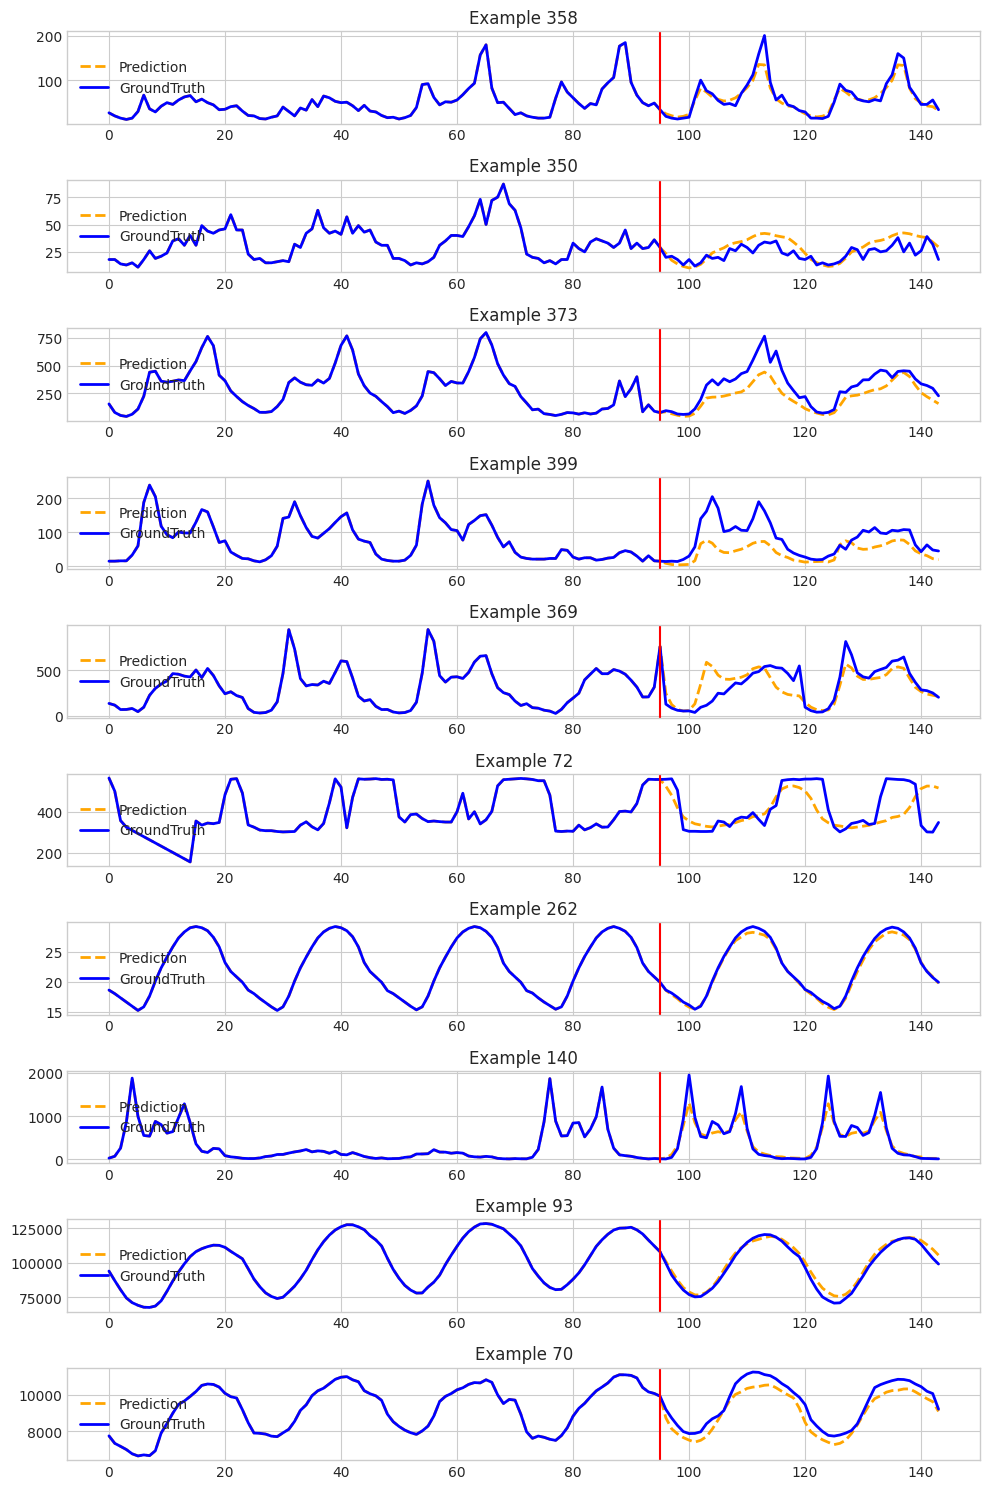

In [11]:
m4_test(
    model,
    train_loader,
    test_loader,
    f"{M4_RESULTS_PATH}/m4_hourly",
    "zeroshot",
    device,
)

#### **Observation:** _The zero-shot results are better than Naive2, but still there is room for improvement._

## Fine-tune on M4 data

We have seen in the validation experiments that fintuning TTM with L1 loss (or MAE) is more suitable for M4 hourly data.
Moreover, fine-tuning the entire TTM with dropouts=0.0 gived more generalizability. 

In [12]:
model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1",
    revision="main",
    prediction_filter_length=M4_FORECAST_HORIZON,
    head_dropout=0.0,
    dropout=0.0,
    loss="mae",
).to("cuda")

#### Now, fine-tune the model on train split of M4-hourly

In [13]:
m4_finetune(model, train_data, batch_size=16, save_path=f"{M4_RESULTS_PATH}/m4_hourly/finetune")

/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Step,Training Loss
26,0.322900
52,0.298500
78,0.283900
104,0.285400
130,0.276800
156,0.282900
182,0.284200
208,0.268300
234,0.275400
260,0.260300


/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/dccstor/dnn_forecasting/conda_envs/envs/fm/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX i

#### Load the fine-tuned model

In [14]:
model = TinyTimeMixerForPrediction.from_pretrained(f"{M4_RESULTS_PATH}/m4_hourly/finetune/ttm_pretrained/").to(device)

#### Evaluate the performance

0
test shape: (414, 48, 1)


/tmp/ipykernel_1173918/862177703.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  naive2_forecasts = np.array([v[~np.isnan(v)] for v in naive2_forecasts])
/tmp/ipykernel_1173918/862177703.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([v[~np.isnan(v)] for v in values[groups == group_name]])


==================== M4 Evaluation Metric ====================
Data = Hourly, MSE = 1104609.3651948185
Data = Hourly, Naive2 MSE = 3187913.2677412867

Data = Hourly, MAE = 252.4890627959552
Data = Hourly, Naive2 MAE = 366.7593400292926

Data = Hourly, MAPE = 0.14896195627699846 (not %)
Data = Hourly, Naive2 MAPE = 0.22019547019161032 (not %)

Data = Hourly, MASE = 1.0915316290531656
Data = Hourly, Naive2 MASE = 2.3950400131234

Data = Hourly, sMAPE = 0.06147925085009656 (not %)
Data = Hourly, Naive2 sMAPE = 0.09191439057157862 (not %)

Data = Hourly, OWA = 0.5623109296877316 (should be <1 to be better than naive)


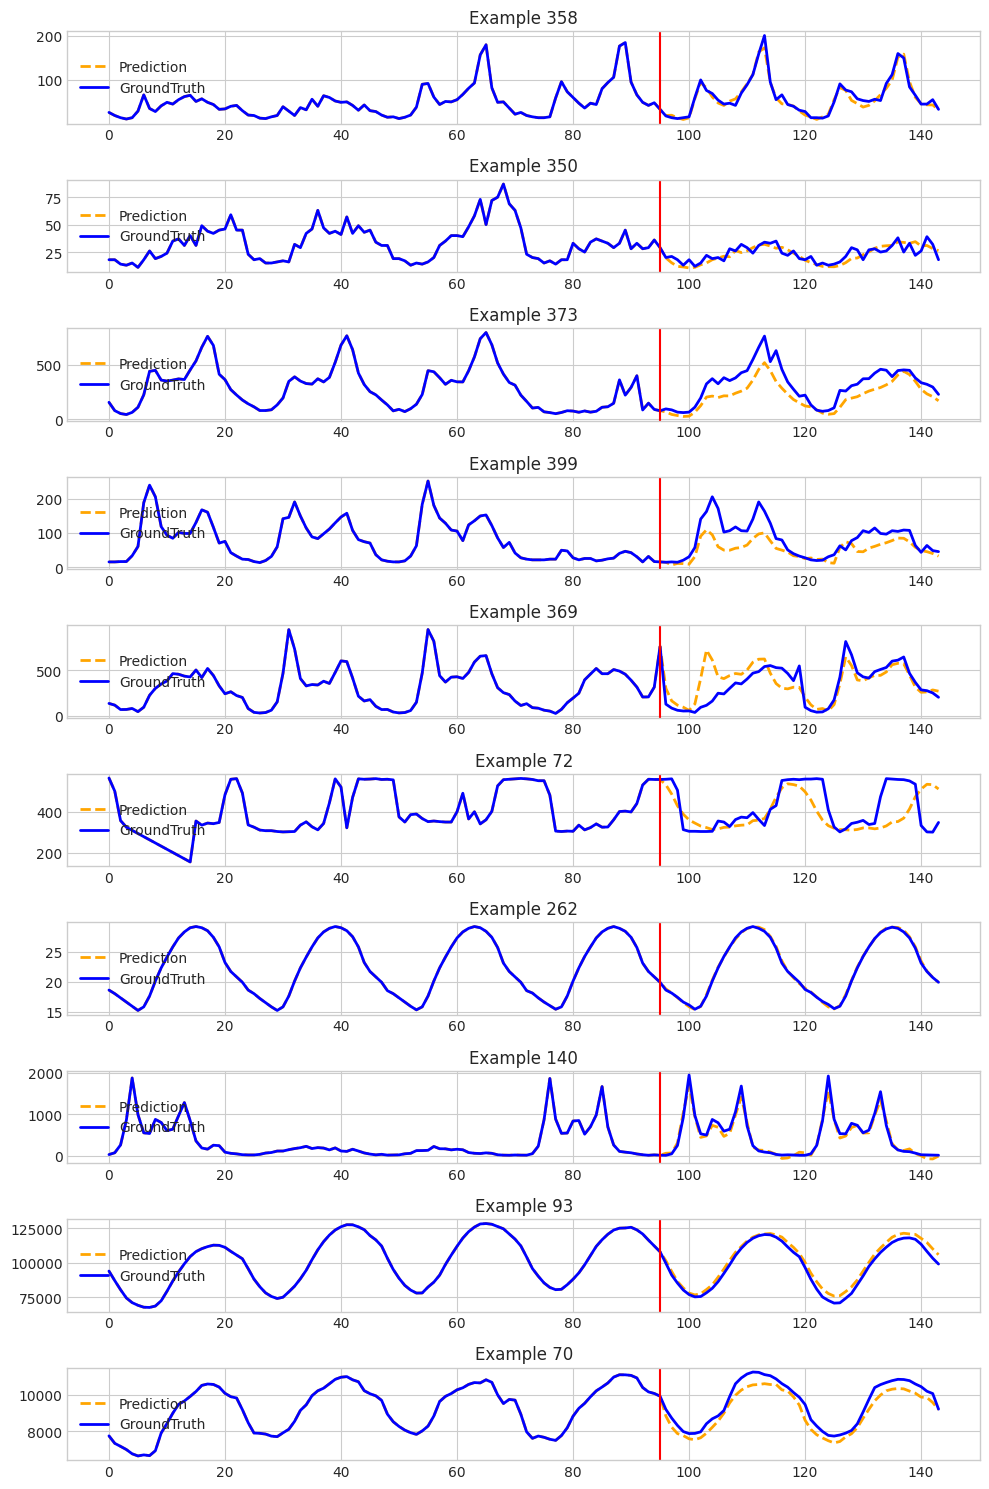

In [15]:
m4_test(
    model,
    train_loader,
    test_loader,
    f"{M4_RESULTS_PATH}/m4_hourly",
    "finetune",
    device,
)

## Reporting TTM performance on M4-hourly data in comparison with statistical baselines 

StatisticalEnsemble is an ensemble forecaster comprised of [AutoARIMA, AutoETS, AutoCES, DynamicOptimizedTheta].

### Metric: MASE

| Model               | Metric | Score |
|---------------------|--------|-------|
| Naive2              | MASE   | 2.395 |
| StatisticalEnsemble | MASE   | 1.299 |
| Seasonal Naive      | MASE   | 1.193 |
| TTM                 | MASE   | 1.092 |

### Metric: sMAPE

| Model               | Metric  | Score |
|---------------------|---------|-------|
| Naive2              | sMAPE   | 0.092 |
| StatisticalEnsemble | sMAPE   | 0.077 |
| Seasonal Naive      | sMAPE   | 0.070 |
| TTM                 | sMAPE   | 0.061 |

### Metric: Inference time

This experiment is done in CPU (16 cores) for a fair comparison. The following table shows the inference time for the full M4 hourly test set.

| Model                 | Metric  | Score |
|-----------------------|---------|-------|
| StatisticalEnsemble   | Time(secs) | 2601.780504 |
| Seasonal Naive        | Time(secs) | 1.299 |
| TTM (batch size = 64) | Time(secs) | 0.513 |